In [11]:
%matplotlib inline

In [12]:
import psycopg2
import geopandas as gpd
import pandas as pd
import numpy as np
import json

host = "localhost"
port = 5433
database = "harbin"
user     = "osmuser"
password = "pass"

con = psycopg2.connect(
    host=host, port=port, database=database, user=user, password=password)
con.set_client_encoding("UTF8")

In [13]:
bfmap_ways = gpd.read_postgis("select gid, osm_id, source, target, reverse, priority, geom from bfmap_ways;", con)
ways = pd.read_sql_query("select id as osm_id, tags, nodes from ways;", con)

con.close()

In [14]:
roads = bfmap_ways.merge(ways, on='osm_id')

## visualizing map

<AxesSubplot:>

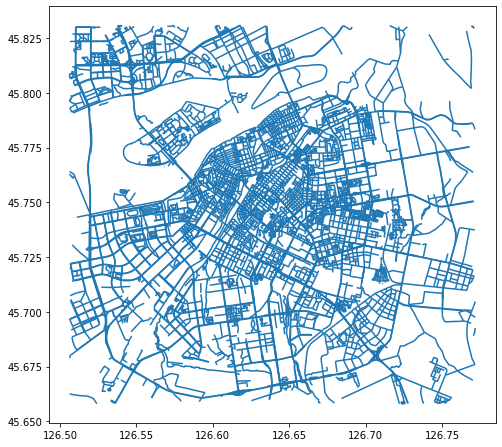

In [15]:
bfmap_ways.plot(figsize=(8, 8))

## visualizing route

In [16]:
print(bfmap_ways.head())
print(bfmap_ways.length.head())
roads.head()['tags']

   gid    osm_id      source      target  reverse  priority  \
0    1  26509856   290573873   290576137      1.0       5.0   
1    2  26509856   290576137  5030596392      1.0       5.0   
2    3  30320423   334304160   403208780     -1.0       1.4   
3    4  30320423   403208780  5905870254     -1.0       1.4   
4    5  30320423  5905870254  2504890750     -1.0       1.4   

                                                geom  
0  LINESTRING (126.56599 45.78482, 126.56719 45.7...  
1  LINESTRING (126.56719 45.78370, 126.56730 45.7...  
2  LINESTRING (126.59121 45.76401, 126.59147 45.7...  
3  LINESTRING (126.59147 45.76390, 126.59244 45.7...  
4  LINESTRING (126.59244 45.76340, 126.59301 45.7...  
0    0.001645
1    0.000145
2    0.000293
3    0.001086
4    0.000635
dtype: float64


/home/jingyi/fyp/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


0              "source"=>"Yahoo", "highway"=>"service"
1              "source"=>"Yahoo", "highway"=>"service"
2    "name"=>"上海街", "lanes"=>"4", "oneway"=>"yes", ...
3    "name"=>"上海街", "lanes"=>"4", "oneway"=>"yes", ...
4    "name"=>"上海街", "lanes"=>"4", "oneway"=>"yes", ...
Name: tags, dtype: object

310        311
1183      1184
1190      1191
2132      2133
2606      2607
2821      2822
3479      3480
3532      3533
3538      3539
3554      3555
8444      8445
8447      8448
8948      8949
8980      8981
8988      8989
8991      8992
9190      9191
9194      9195
9260      9261
9277      9278
9284      9285
10244    10245
10245    10246
10279    10280
10311    10312
12220    12221
Name: gid, dtype: int64


<AxesSubplot:>

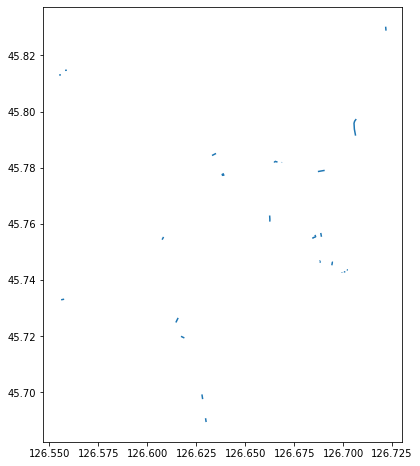

In [17]:
# path = np.loadtxt("/tmp/road.txt")
# path = [3480, 2131, 10311, 8945, 2821, 10280, 10287, 311, 8981, 10246, 10249, 10245, 8982, 312, 10288, 10281, 2822, 8946, 10312, 2133, 8988, 12221, 9258, 3555, 3539, 9284, 9278, 1190, 8042, 8045, 8050, 1184, 8048, 8448, 8445, 2607, 3533, 9191, 9195, 9197, 3502, 9180, 8044, 1191, 9279, 9285, 3540, 3556, 9261, 12220, 8989, 8949, 8992, 8950, 8988, 12221, 9258, 3555, 3539, 9284, 9278]
path = [3480, 3480, 10280, 311, 8981, 10246, 10246, 10246, 10245, 2822, 10312, 2133, 12221, 12221, 3555, 9278, 1184, 8448, 8445, 8445, 2607, 3533, 9191, 9195, 1191, 9285, 9261, 8989, 8949, 8949, 8992, 3539, 9278]
# path  = [674131937]

road = roads[roads.gid.isin(path)]
print(road.gid)
road.plot(figsize=(8, 8))

## visualizing gps on map

In [18]:
# from bokeh.plotting import figure, output_notebook, show
# import numpy as np
# import datashader
# from bokeh.tile_providers import STAMEN_TERRAIN, STAMEN_TONER_BACKGROUND
# from bokeh.models import (
#     Range1d, WMTSTileSource, ColumnDataSource, HoverTool
# )
# output_notebook()

# def plot_gps(gps, line_width=2):
#     plot_width  = int(600)
#     plot_height = int(plot_width//1.2)
#     #x_range, y_range = ((126.506130,126.771862), (45.657920,45.830905))
#     x, y = datashader.utils.lnglat_to_meters(gps[:,0], gps[:, 1])
#     x_range = Range1d(start=x.min()-100, end=x.max()+100, bounds=None)
#     y_range = Range1d(start=y.min()-100, end=y.max()+100, bounds=None)
#     p = figure(tools='wheel_zoom,pan,reset,hover,save',# x_range=x_range, y_range=y_range,
#                plot_width=plot_width, plot_height=plot_height)

#     p.line(x=x, y=y, line_width=line_width)
#     p.circle(x=x, y=y, size=5, fill_color="#F46B42", line_color=None, line_width=1.5)
#     p.add_tile(STAMEN_TERRAIN)
#     return p

In [19]:
from bokeh.plotting import figure, output_notebook, output_file, show
import numpy as np
import datashader
from bokeh.tile_providers import STAMEN_TERRAIN, STAMEN_TONER_BACKGROUND, get_provider
from bokeh.models import (
    Range1d, WMTSTileSource, ColumnDataSource, HoverTool
)

output_notebook()
tile_provider = get_provider(STAMEN_TERRAIN)

def plot_gps(lon, lat, line_width=0.1):
    plot_width  = int(600)
    plot_height = int(plot_width//1.2)
    x, y = datashader.utils.lnglat_to_meters(lon, lat)
    x_range = Range1d(start=x.min()-200, end=x.max()+200, bounds=None)
    y_range = Range1d(start=y.min()-200, end=y.max()+200, bounds=None)
    p = figure(tools='wheel_zoom,pan,reset,hover,save', x_range=x_range, y_range=y_range,
               plot_width=plot_width, plot_height=plot_height)
    p.add_tile(tile_provider)
    
    p.line(x=x, y=y, line_width=line_width)
    p.circle(x=x, y=y, size=5, fill_color="#F46B42", line_color=None, line_width=1.5)
    return p

Loading BokehJS ...

In [41]:
# gps = np.loadtxt("/tmp/gps.txt")
# p = plot_gps(gps, 3)
# show(p)
linestr = 'LINESTRING(126.65464 45.7912,126.65164 45.788216,126.6483 45.78724,126.648224 45.78722,126.648056 45.78716,126.6484 45.782494,126.651764 45.77726,126.646706 45.772884000000005,126.6378 45.770668,126.634544 45.769554,126.634476 45.76945,126.63226 45.769157,126.6313 45.770973,126.63487 45.7728,126.63652 45.773205,126.64025 45.775368,126.644875 45.778187,126.6486 45.780346,126.65087 45.778343,126.649895 45.780502)'
gpslist = linestr[11:-1].split(',')
lon = [float(item.split(' ')[0]) for item in gpslist]
lat = [float(item.split(' ')[1]) for item in gpslist]
print(lon)
print(lat)
show(plot_gps(lon, lat))



[126.65464, 126.65164, 126.6483, 126.648224, 126.648056, 126.6484, 126.651764, 126.646706, 126.6378, 126.634544, 126.634476, 126.63226, 126.6313, 126.63487, 126.63652, 126.64025, 126.644875, 126.6486, 126.65087, 126.649895]
[45.7912, 45.788216, 45.78724, 45.78722, 45.78716, 45.782494, 45.77726, 45.772884000000005, 45.770668, 45.769554, 45.76945, 45.769157, 45.770973, 45.7728, 45.773205, 45.775368, 45.778187, 45.780346, 45.778343, 45.780502]


<AxesSubplot:>

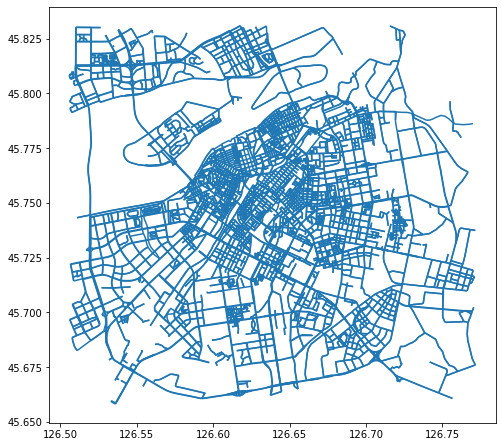

In [42]:
osmnx_ways = gpd.read_file('/home/jingyi/fyp/fmm/example/data/harbin.tmp/edges.shp')
osmnx_ways.plot(figsize=(8, 8))


In [22]:
osmnx_ways.head()

# osmnx_roads = osmnx_ways.merge(ways, on='osm_id')

,osmid,oneway,highway,length,bridge,lanes,name,junction,ref,tunnel,maxspeed,service,access,u,v,key,fid,geometry
0,674131937,1,trunk_link,92.416,None,None,None,None,None,None,None,None,None,334304104,5374253272,0,0,"LINESTRING (126.64598 45.71731, 126.64500 45.7..."
1,"[34645928, 395949525]",1,trunk,709.943,yes,2,和兴路,None,None,None,None,None,None,334304104,3987519386,0,1,"LINESTRING (126.64598 45.71731, 126.64480 45.7..."
2,30320423,1,secondary,24.518,None,4,上海街,None,None,None,None,None,None,334304160,403208780,0,2,"LINESTRING (126.59121 45.76401, 126.59147 45.7..."
3,"[34657514, 34653332]",1,"['primary_link', 'primary']",481.410,None,5,友谊路,None,None,None,None,None,None,334304160,3967252757,0,3,"LINESTRING (126.59121 45.76401, 126.58861 45.7..."
4,30320423,1,secondary,88.548,None,4,上海街,None,None,None,None,None,None,334304164,3058314704,0,4,"LINESTRING (126.59660 45.75987, 126.59725 45.7..."


126        126
128        128
140        140
154        154
1305      1305
1508      1508
1509      1509
1511      1511
1518      1518
2223      2223
2357      2357
3191      3191
3194      3194
3988      3988
3993      3993
4577      4577
4586      4586
4590      4590
4593      4593
5030      5030
5036      5036
5037      5037
5041      5041
5099      5099
5824      5824
5827      5827
5834      5834
5837      5837
5847      5847
5868      5868
5924      5924
5931      5931
5935      5935
5946      5946
5953      5953
6006      6006
6084      6084
6826      6826
6848      6848
6859      6859
6917      6917
7578      7578
7580      7580
7586      7586
7588      7588
9714      9714
9717      9717
9719      9719
9737      9737
9739      9739
11097    11097
11100    11100
14096    14096
Name: fid, dtype: int64
126     140.289
128     140.087
140     131.434
154     242.522
1305    106.284
Name: length, dtype: float64
126     0.001364
128     0.001743
140     0.001618
154     0.002354
1305

/home/jingyi/fyp/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


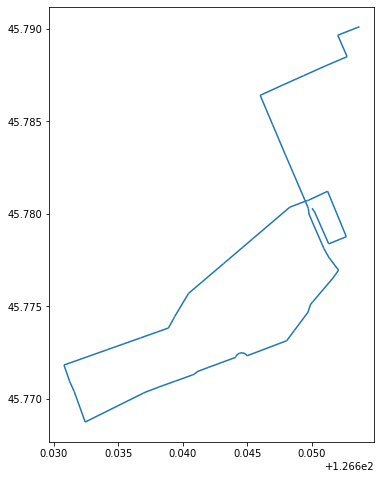

In [40]:
path = [128, 126, 6859, 6848, 6006, 140, 6826, 5099, 14096, 5868, 154, 1509, 4593, 4586, 4577, 4590, 5924, 3988, 3993, 2357, 2223, 9719, 9717, 9714, 6084, 5036, 5030, 6917, 7588, 7586, 7578, 7580, 3191, 3194, 1305, 5037, 5041, 11100, 11097, 5837, 5834, 5847, 5931, 5935, 5946, 5953, 5827, 5824, 1511, 1508, 1518, 9737, 9739]
osmnx_road = osmnx_ways[osmnx_ways.fid.isin(path)]
print(osmnx_road.fid)
osmnx_road.plot(figsize=(8, 8))
print(osmnx_road['length'].head())
print(osmnx_road.length.head())

In [24]:
# osmnx_ways.columns = ['osm_id', 'oneway', 'highway', 'length', 'bridge', 'lanes', 'name',
#        'junction', 'ref', 'tunnel', 'maxspeed', 'service', 'access', 'u', 'v',
#        'key', 'fid', 'geometry']

277      0.001098
281      0.000108
301      0.001395
500      0.000860
501      0.009462
506      0.002248
507      0.000230
509      0.001988
512      0.000296
515      0.001099
520      0.000560
522      0.001054
544      0.000230
2059     0.001404
2080     0.001173
2089     0.001399
2097     0.002852
2113     0.001249
2116     0.001348
2120     0.001736
2964     0.001372
2965     0.002444
2966     0.000318
2969     0.003185
2972     0.000536
3437     0.000356
3444     0.000214
3483     0.000215
7697     0.005406
7708     0.000125
7711     0.007828
7712     0.000326
8626     0.001336
10235    0.001368
12050    0.001545
12052    0.001635
12066    0.000905
12080    0.001482
12097    0.001658
12099    0.000860
12100    0.000905
12131    0.002418
12135    0.002418
12136    0.002444
12943    0.008258
dtype: float64
277       90.419
281       11.031
301      135.105
500       78.630
501      840.936
506      218.529
507       19.217
509      194.671
512       28.794
515      105.721
520  

/home/jingyi/fyp/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


<AxesSubplot:>

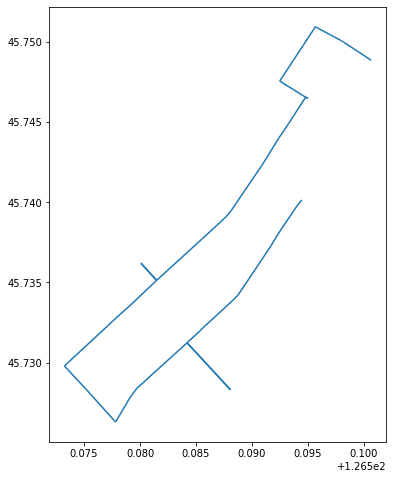

In [37]:
path = [ 8627, 10236,  3484,   278,  2090,   282,   302,  2060,  2121,  2117,
         2081,   508,   545,   507,  2114,   510,   513,   516,  2098,   521,
          523, 12051, 12081, 12053, 12098,   501, 12100,   501, 12101, 12067,
        12100,   502,  3438,  3445,  7698,  7709,  7713,  7712,  2966, 12136,
        12132, 12137,  2965,  2967,  2970,  2973, 12944]
path = [x - 1 for x in path]
osmnx_road = osmnx_ways[osmnx_ways.fid.isin(path)]
print(osmnx_road.length)
print(osmnx_road['length'])
osmnx_road.plot(figsize=(8, 8))

In [35]:
osmnx_ways.columns
ways.columns

Index(['osm_id', 'tags', 'nodes'], dtype='object')

In [26]:
osmnx_ways

,osmid,oneway,highway,length,bridge,lanes,name,junction,ref,tunnel,maxspeed,service,access,u,v,key,fid,geometry
0,674131937,1,trunk_link,92.416,None,None,None,None,None,None,None,None,None,334304104,5374253272,0,0,"LINESTRING (126.64598 45.71731, 126.64500 45.7..."
1,"[34645928, 395949525]",1,trunk,709.943,yes,2,和兴路,None,None,None,None,None,None,334304104,3987519386,0,1,"LINESTRING (126.64598 45.71731, 126.64480 45.7..."
2,30320423,1,secondary,24.518,None,4,上海街,None,None,None,None,None,None,334304160,403208780,0,2,"LINESTRING (126.59121 45.76401, 126.59147 45.7..."
3,"[34657514, 34653332]",1,"['primary_link', 'primary']",481.410,None,5,友谊路,None,None,None,None,None,None,334304160,3967252757,0,3,"LINESTRING (126.59121 45.76401, 126.58861 45.7..."
4,30320423,1,secondary,88.548,None,4,上海街,None,None,None,None,None,None,334304164,3058314704,0,4,"LINESTRING (126.59660 45.75987, 126.59725 45.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,845985083,0,unclassified,29.143,None,None,carpark access,None,None,None,None,None,None,7892801842,7892801840,0,14958,"LINESTRING (126.60524 45.72077, 126.60533 45.7..."
14959,846168148,0,residential,49.716,None,None,None,None,None,None,None,None,None,7894498546,7894498547,0,14959,"LINESTRING (126.66780 45.74546, 126.66716 45.7..."
14960,34781488,0,tertiary,48.170,None,None,鸿翔路 - Hongxiang Road,None,None,None,None,None,None,7894498546,3107953561,0,14960,"LINESTRING (126.66780 45.74546, 126.66778 45.7..."
14961,34781488,0,tertiary,126.791,None,None,鸿翔路 - Hongxiang Road,None,None,None,None,None,None,7894498546,3472714258,0,14961,"LINESTRING (126.66780 45.74546, 126.66786 45.7..."


In [92]:
type(osmnx_ways.fid.values)

numpy.ndarray

In [93]:
osmnx_ways.fid.values

array([    0,     1,     2, ..., 14960, 14961, 14962])

In [94]:
osmnx_ways.osmid.values

array(['674131937', '[34645928, 395949525]', '30320423', ..., '34781488',
       '34781488', '846168148'], dtype=object)

In [95]:
type(osmnx_ways.osmid.values)

numpy.ndarray

In [96]:
osmnx_ways.length.values * 1000

/home/jingyi/fyp/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


array([1.08474481, 8.28330724, 0.29270958, ..., 0.43402872, 1.14293822,
       0.63920779])

In [99]:
tags = roads.tags.apply(lambda s: json.loads('{'+s.replace('=>', ':')+'}'))

In [100]:
tags

0                {'source': 'Yahoo', 'highway': 'service'}
1                {'source': 'Yahoo', 'highway': 'service'}
2        {'name': '上海街', 'lanes': '4', 'oneway': 'yes',...
3        {'name': '上海街', 'lanes': '4', 'oneway': 'yes',...
4        {'name': '上海街', 'lanes': '4', 'oneway': 'yes',...
                               ...                        
15091             {'oneway': 'yes', 'highway': 'tertiary'}
15092             {'oneway': 'yes', 'highway': 'tertiary'}
15093             {'oneway': 'yes', 'highway': 'tertiary'}
15094             {'oneway': 'yes', 'highway': 'tertiary'}
15095             {'oneway': 'yes', 'highway': 'tertiary'}
Name: tags, Length: 15096, dtype: object

In [101]:
highways = tags.apply(lambda d: d.get("highway", "unclassified"))

In [102]:
highways

0          service
1          service
2        secondary
3        secondary
4        secondary
           ...    
15091     tertiary
15092     tertiary
15093     tertiary
15094     tertiary
15095     tertiary
Name: tags, Length: 15096, dtype: object

In [106]:
len(highways.unique())
highways.unique()

array(['service', 'secondary', 'trunk', 'tertiary', 'residential',
       'unclassified', 'trunk_link', 'primary', 'primary_link',
       'tertiary_link', 'secondary_link', 'living_street', 'motorway',
       'motorway_link'], dtype=object)

In [110]:
osmnx_ways.highway.values[:5]

array(['trunk_link', 'trunk', 'secondary', "['primary_link', 'primary']",
       'secondary'], dtype=object)

In [137]:
json.loads('["a", "b"]')
def get_highway(s):
    types = s
    if s[0] == '[':
        types = json.loads(s.replace("'", '"'))
        types = types[0]
    return types
highways = osmnx_ways.highway.apply(get_highway)

In [138]:
highways.unique()

array(['trunk_link', 'trunk', 'secondary', 'primary_link', 'tertiary',
       'primary', 'residential', 'unclassified', 'tertiary_link',
       'secondary_link', 'living_street', 'disused', 'motorway',
       'motorway_link'], dtype=object)

In [139]:
len(highways.unique())

14

In [149]:
def get_lane(s):
    types = s
    if s is None:
        types = '0'
    elif s[0] == '[':
        types = json.loads(s.replace("'", '"'))
        types = types[0]
    return types
lanes = osmnx_ways.lanes.apply(get_lane)
print(len(lanes.unique()))
lanes.unique()


7


array(['0', '2', '4', '5', '3', '6', '1'], dtype=object)

In [150]:
lanes = tags.apply(lambda d: d.get("lanes", "0"))
lanes.unique()

array(['0', '4', '3', '2', '5', '6', '1'], dtype=object)

In [153]:
def get_way(s):
    types = s
    if isinstance(s, str) and s[0] == '[':
        types = json.loads(s.replace("'", '"'))
        types = types[0]
    return types
one_way = osmnx_ways.oneway
one_way.unique()

In [1]:
import db_osmnx_utils


In [2]:
dict_u = db_osmnx_utils.get_dict_u()

In [3]:
len(dict_u[0])

14964

In [4]:
dict_s1 = db_osmnx_utils.get_dict_s1()
len(dict_s1[0])

14964

In [5]:
types = np.sort(highways.unique())
type_id = {}
for i in range(len(types)):
    type_id[types[i]] = i
df = pd.concat([osmnx_ways.fid, highways.apply(lambda t: type_id.get(t))],
                   axis=1, keys=['fid', 'type_id'])

NameError: name 'np' is not defined

In [6]:
dict_s1 = {}
dict_s1[0] = 0
for _, row in df.iterrows():
    dict_s1[row.fid + 1] = row.type_id

NameError: name 'df' is not defined

In [7]:
dict_s2 = db_osmnx_utils.get_dict_s2()
len(dict_s2[0])

14964

In [8]:
dict_s3 = db_osmnx_utils.get_dict_s3()
len(dict_s3[0])

14964

In [28]:
lengths = db_osmnx_utils.get_lengths()

/home/jingyi/fyp/deepgtt/harbin/python-transformer/db_osmnx_utils.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lengths = osmnx_ways.length.values * 1000


In [29]:
len(lengths)

14964

In [43]:
nodes = gpd.read_file('/home/jingyi/fyp/fmm/example/data/harbin.tmp/nodes.shp')

In [44]:
nodes.head()

,y,x,osmid,highway,geometry
0,45.717311,126.645977,334304104,None,POINT (126.64598 45.71731)
1,45.764013,126.591206,334304160,None,POINT (126.59121 45.76401)
2,45.759870,126.596597,334304164,None,POINT (126.59660 45.75987)
3,45.755678,126.604186,334304167,None,POINT (126.60419 45.75568)
4,45.755541,126.585592,334304432,None,POINT (126.58559 45.75554)


In [45]:
nodes.columns

Index(['y', 'x', 'osmid', 'highway', 'geometry'], dtype='object')